In [1]:
__author__ = "Lars Engesæth / NMBU"
__email__ = 'laen@nmbu.no'

# Imports
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedKFold
import nibabel as nib
import copy
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
import pickle
import statistics


#### Exploratory analysis and investigation of clinical dataset

In [2]:
# Exploratory analysis
multiblock_data = pd.read_excel("220126 OxyTarget datasheet.xlsx", nrows=192)
print(multiblock_data.shape)

(192, 99)


In [3]:
# Remove patients that has withdrawn their consent.
multiblock_data = multiblock_data[multiblock_data['Date of inclusion'] != "Withdrawn consent"]

print(multiblock_data.shape)

(188, 99)


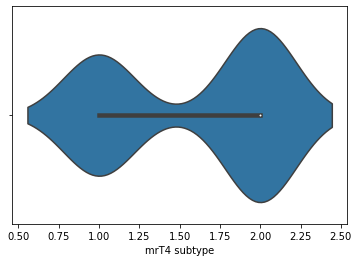

In [4]:
plt.figure(1)
sns.violinplot(x=multiblock_data['mrT4 subtype'])
plt.show()

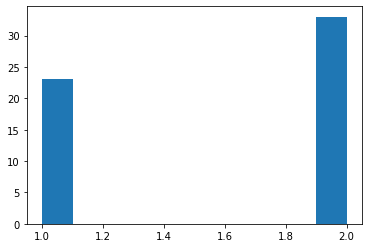

In [5]:
plt.figure(2)
plt.hist(multiblock_data["mrT4 subtype"])
plt.show()

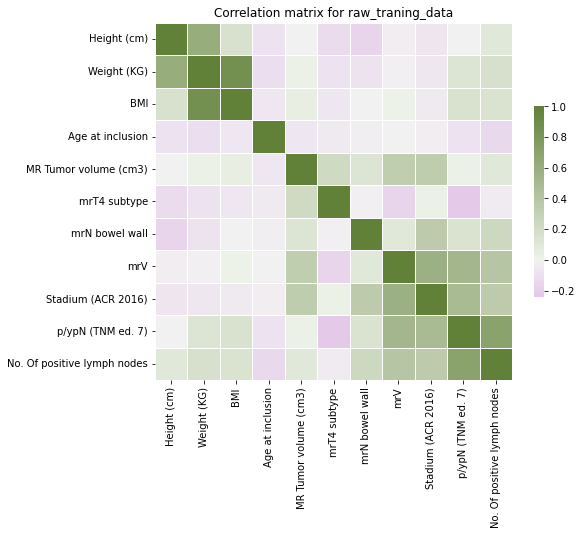

In [6]:
# Correlation matrix to inspect features.
corr = multiblock_data.corr()
f, ax = plt.subplots(figsize=(8, 7))
cmap = sns.diverging_palette(300, 110, as_cmap=True)
plt.title('Correlation matrix for raw_traning_data')
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [7]:
# Ensuring that dummies work as expected for onehotencoding.
column_list = ['Blood samples at inclusion', 'Sex (M/F)', 'Location primary tumor']
dummy_2 = pd.get_dummies(multiblock_data[column_list], drop_first=True)

In [8]:
# Double checking the shape of the DataFrame
print(multiblock_data.shape)


(188, 99)


In [9]:
# Concatinating the main dataset and the dummy_2 variables. Gender is now listed twice.

result = pd.concat([multiblock_data, dummy_2], axis=1)

In [10]:
print(multiblock_data["Location primary tumor"].isna().sum())
print(multiblock_data.isna().sum())

0
ID                              0
Date of inclusion               0
Blood samples at inclusion      1
Sex (M/F)                       0
Height (cm)                     1
                             ... 
Other cancer                  170
Included in other study       164
Last registered alive           1
Further follow up               1
Comment                       163
Length: 99, dtype: int64


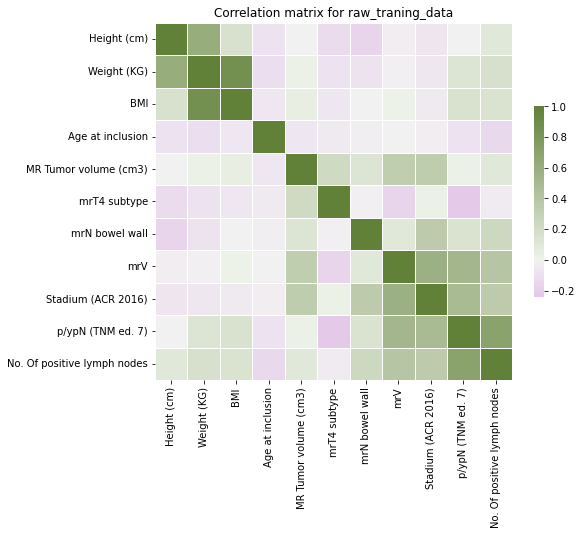

In [11]:
# New correlation plot:

corr = multiblock_data.corr()
f, ax = plt.subplots(figsize=(8, 7))
cmap = sns.diverging_palette(300, 110, as_cmap=True)
plt.title('Correlation matrix for raw_traning_data')
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

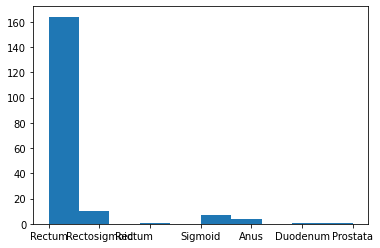

In [12]:
# Checking what the column distribution 
plt.figure()
plt.hist(multiblock_data["Location primary tumor"])
plt.show()

#### Making a practice data set to work with dummies, removal and cleaning of the dataset

In [13]:
# Practice:
# I make a practice data set and remove some columns that contain strings and datetime.

practice_data = multiblock_data[multiblock_data.columns[0:9]]
practice_data = practice_data.drop(columns=['Symptoms', 'Date of inclusion'])

In [14]:
# I get dummies from the practice set. These columns must be dropped later.

columns = ['Blood samples at inclusion', 'Sex (M/F)']
dummy_3 = pd.get_dummies(practice_data[columns], drop_first=True)

In [15]:
practice_data_2 = practice_data.drop(columns=columns)

In [16]:
practice_data_3 = pd.concat([practice_data_2, dummy_3], axis=1)

In [17]:
# Reset the index so that we can index all values from 0-len(dataset)

multiblock_data.reset_index(drop=True, inplace=True)

In [19]:
dattime = multiblock_data.iloc[:, 1][2]
print(dattime.tzinfo)

None


#### Treating unavoidable problems with data set (NaN and bad features)

In [20]:
# These columns are too bad to be kept. Either lacking too many data points, they are unique strings, or hard to separate. 
# Or a combination.
columns_to_drop = ['Symptoms', # done
                   'Biopsy histology ID', # missing #done
                   'KRAS', # pos/neg, 144 nan # done
                   'NRAS', # pos/neg, 144 nan # done
                   'BRAF', # pos/neg/uncertain, 144 nan #done
                   'Codon', # many nan done
                   'Date MR w/diagnose', # 188 unique values. Maybe the date is relevant to extract # done 
                   'mrT4 subtype', # 132 nan, but allegedly an important feature to keep. # done
                   'Date other radiology', # 179 unique values # done
                   'Palliative therapy', # 170 nan # done
                   'Description post-CRT MR', # 67 unique, 120 nan. Information already contained in other columns # done
                   'Histology reference no.', # 157 unique, 31 missing #done
                   'Comments pathology', # unique descriptions and 166 nan #done
                   'Comment adjuvant treatment', # 35 unique, remaining are nan # done
                   'Date metastatic disease', # same number as above. # done
                   'Date local recurrence', # 179 nan-values. However, extremely important information. # done
                   'Type of local recurrence', # 180 nan-values, and the non-nan are unique descriptions. # done
                   'Other cancer', # 175 nan values, and the descriptions in the cells are not useful #done
                   'Included in other study', # nan-filled and not useful #done
                   'Comment', # Nan or unique values # 
                   'Other exams' # Unique comments or missing # done
                   
                  ]

print('Number of unique values: ', multiblock_data['Other exams'].nunique())
print('Number of NaN values:    ', multiblock_data['Other exams'].isna().sum())

## Not removed, but must be considered:
# MSI
# mrN bekkenvegg
# mrV

# Dato oppstart preoperativ kjemoterapi; 69 unique dates, but 117 nan
# Type preoperativ kjemoterapi; same as above, but 10 unique treatments
# Dato preoperativ radioterapi; almost same as above
# Type preoperativ radioterapi; almost same as above
# Dato avslutt preoperativ radioterapi; relevant in combination with above date
# Dato MR kontroll etter preoperativ CRT; almost same as above 

# Type kirurgi                    (opersjonsbeskrivelse); categorical
# Antall lymfeknuter undersøkt; string format for integers
# CEA baseline; maybe problematic number format. Some nans
# Neutrofile; maybe problematic number format. Some nans
# Lymfocytter; same as two above 
# Monocytter; same as above
# Eosinofile; same as above
# Basofile; same as above
# Kalsium total; same as above
# Klorid; same as above
# Karbamid; same as above

# Blodtype; must be converted to dummies. It also has +A which must be considered
# Adjuvant behandling; converted to dummies
# Type metastase; 155 nan but extremely important information
# MORS; the information is contained in "OS-event", but the date may be relevant. 56 uinque dates, 132 nan
# Tid til PFS-event; we need to define missing values as something else here. The lack of data means that the patient lived.
# Tid til OS-event; same as above.

Number of unique values:  17
Number of NaN values:     169


In [21]:
# Time to remove the unwanted features.
extracted_features = multiblock_data.drop(columns=columns_to_drop)

# extracted_features is the new dataframe to change.
extracted_features.replace('-', np.NaN, inplace=True)

# Optional replacements:
extracted_features.replace('Missing', np.NaN, inplace=True)
extracted_features.replace('Pending', np.NaN, inplace=True)

In [110]:
# Double checking that the script correctly recognizes the datatype.
for i in range(len(extracted_features.columns)):
    print('Name of column:', extracted_features.columns[i])
    #print('Value of data: ', extracted_features.iloc[:, i][2])
    print('Type of data:  ', type(extracted_features.iloc[:, i][2]))
    print('Number of NaN: ', extracted_features.iloc[:, i].isna().sum())
    if (isinstance(extracted_features.iloc[:, i][2], str) or 
    isinstance(extracted_features.iloc[:, i][7], str) or
    isinstance(extracted_features.iloc[:, i][19], str)):
                  print('         __This is a string__')
    print('\n')
    

Name of column: ID
Type of data:   <class 'str'>
Number of NaN:  0
         __This is a string__


Name of column: Date of inclusion
Type of data:   <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Number of NaN:  0


Name of column: Blood samples at inclusion
Type of data:   <class 'str'>
Number of NaN:  1
         __This is a string__


Name of column: Sex (M/F)
Type of data:   <class 'str'>
Number of NaN:  0
         __This is a string__


Name of column: Height (cm)
Type of data:   <class 'numpy.float64'>
Number of NaN:  1


Name of column: Weight (KG)
Type of data:   <class 'numpy.float64'>
Number of NaN:  1


Name of column: BMI
Type of data:   <class 'numpy.float64'>
Number of NaN:  1


Name of column: Age at inclusion
Type of data:   <class 'numpy.float64'>
Number of NaN:  0


Name of column: Date of referral to specialist
Type of data:   <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Number of NaN:  0


Name of column: Location primary tumor
Type of data:   <class 'str'>

In [23]:
ratios = [0.25]

for ratio in ratios:
    print('NaN-ratio: ', ratio)
    excludedlist = []
    includedlist = []
    for column in extracted_features.columns:
        if (extracted_features[column].isna().sum()/len(extracted_features[column])) > ratio:
            # ex: 70/190 > 0.3, meaning, 70 NaN values out of 190 values.
            excludedlist.append(extracted_features[column])
        
        else:
            includedlist.append(extracted_features[column])

    excludeddf = pd.DataFrame(excludedlist)
    Tex = excludeddf.T
    includeddf = pd.DataFrame(includedlist)
    Tix = includeddf.T
    
    print(excludeddf.info(), '\n')

NaN-ratio:  0.25
<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, mrN bowel wall to MORS
Columns: 188 entries, 0 to 187
dtypes: float64(7), object(181)
memory usage: 42.8+ KB
None 



#### Preparing image data sets

In [24]:
# Import DWI features:
DWI = pd.read_csv('DWI3.csv')

FFE = pd.read_csv('FFE.csv')

T1T2 = pd.read_csv('T1T2Sense.csv')

In [25]:
# Add a dummy row for the missing patient. 
# Patient-ID: 122
T1T2 = T1T2.append(T1T2.mean(), ignore_index=True)
T1T2['Name'][81] = 'Target122_img_e1_t30.nii'

C:\Users\Lars\AppData\Local\Temp\ipykernel_182080\1621020222.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  T1T2 = T1T2.append(T1T2.mean(), ignore_index=True)
C:\Users\Lars\AppData\Local\Temp\ipykernel_182080\1621020222.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  T1T2 = T1T2.append(T1T2.mean(), ignore_index=True)
C:\Users\Lars\AppData\Local\Temp\ipykernel_182080\1621020222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T1T2['Name'][81] = 'Target122_img_e1_t30.nii'


In [26]:
# Run this cell maximum 1 time

# Extracting the list of targets
for count, target in enumerate(DWI.Name):
    DWI.Name[count] = target[6:9]

#DWI.Name

for count, target in enumerate(FFE.Name):
    FFE.Name[count] = target[6:9]

#FFE.Name

for count, target in enumerate(T1T2.Name):
    T1T2.Name[count] = target[6:9]

T1T2.Name

C:\Users\Lars\AppData\Local\Temp\ipykernel_182080\2108171054.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DWI.Name[count] = target[6:9]
C:\Users\Lars\AppData\Local\Temp\ipykernel_182080\2108171054.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FFE.Name[count] = target[6:9]
C:\Users\Lars\AppData\Local\Temp\ipykernel_182080\2108171054.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T1T2.Name[count] = target[6:9]


0     103
1     115
2     116
3     118
4     120
     ... 
77    90_
78    94_
79    95_
80    96_
81    122
Name: Name, Length: 82, dtype: object

In [27]:
DWI['Name'] = DWI['Name'].map(lambda x: x.strip('_'))

FFE['Name'] = FFE['Name'].map(lambda x: x.strip('_'))

T1T2['Name'] = T1T2['Name'].map(lambda x: x.strip('_'))

In [28]:
# Sorting the df incrementally
DWI['Name'] = pd.to_numeric(DWI['Name'])
DWI_sorted = DWI.sort_values(by=['Name'])

FFE['Name'] = pd.to_numeric(FFE['Name'])
FFE_sorted = FFE.sort_values(by=['Name'])

T1T2['Name'] = pd.to_numeric(T1T2['Name'])
T1T2_sorted = T1T2.sort_values(by=['Name'])

In [29]:
# To check if the df is sorted.
print(FFE_sorted.Name)

44     27
45     29
46     31
47     32
48     40
     ... 
39    185
40    186
41    187
42    189
43    191
Name: Name, Length: 82, dtype: int64


In [30]:
# List of previously used targets
list_of_targets = DWI_sorted['Name'].tolist()
#print(list_of_targets)
#print(len(list_of_targets))

In [31]:
# making the response column for data set
death = []
inkludsjon22 = pd.read_excel('220126 OxyTarget datasheet.xlsx')

for count, target in enumerate(inkludsjon22['MORS']):
    if not pd.isnull(target):
        death.append(1)
    else:
        death.append(0)


In [32]:
# Shaving the response down for the image dataset
# The response must match the list_of_targets
death_for_subset = []
for target in list_of_targets:
    result = death[target-1]
    death_for_subset.append(result)
    
#print(death_for_subset)

In [33]:
DWI_sorted['response'] = death_for_subset
#DWI_sorted

FFE_sorted['response'] = death_for_subset
#FFE_sorted

T1T2_sorted['response'] = death_for_subset
#T1T2_sorted


In [34]:
# Divide the training set into X and y. 

X = DWI_sorted.iloc[:, :-1]
y = DWI_sorted.iloc[:, -1]

<AxesSubplot:title={'center':'Correlation matrix for X'}>

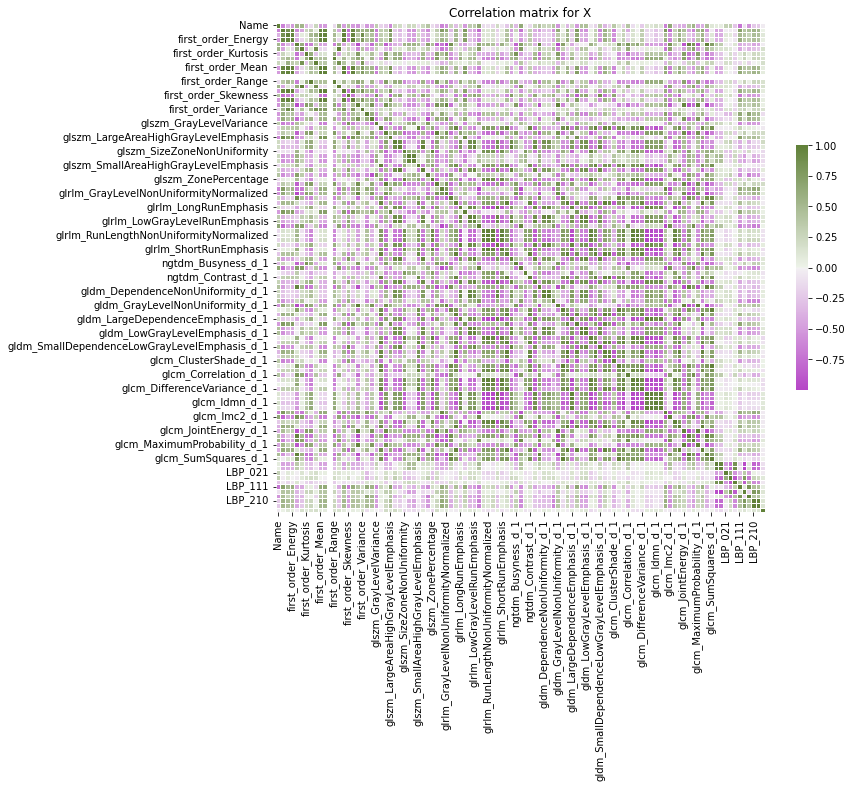

In [35]:
# Correlation matrix to inspect features.

corr = DWI_sorted.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(300, 110, as_cmap=True)
plt.title('Correlation matrix for X')
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [36]:
# Balance of data set:
print(len(death_for_subset))
print(death_for_subset.count(1))      
print('Death rate:', 29/82)

82
29
Death rate: 0.35365853658536583


#### Preparing inclusion data set

In [37]:
new_extracted = []
for index, row in extracted_features.iterrows():
    if row.isna().sum() > 39: # at least 40/78 missing features
        print(index, row.isna().sum())
    else:
        new_extracted.append(row)
        
new_extracted_df = pd.DataFrame(new_extracted)

25 42
29 50
33 46
49 46
61 43
64 40
65 51
66 43
71 45
154 40


In [38]:
# Making a list of strings to compare to the patient indexing

stringified_targets = map(str, list_of_targets)
stringified_targets= (list(stringified_targets))

for count in range(len(stringified_targets)):
    stringified_targets[count] = stringified_targets[count].zfill(3)
    
#print(stringified_targets)
#print(len(stringified_targets))

In [39]:
# Extracting patients from inclusion data

clinical_cohort = []
for number in stringified_targets:
    for index, row in new_extracted_df.iterrows():
        if number == row['ID'][10:13]:
            clinical_cohort.append(row)



In [40]:
# The list is 81 patients long with 78 features each.

print(len(clinical_cohort))
print(len(clinical_cohort[3]))

81
78


In [41]:
clinical_cohort_df = pd.DataFrame(clinical_cohort)

In [42]:
# Removing nan-filled features. 

ratios = [0.25]

for ratio in ratios:
    print('NaN-ratio: ', ratio)
    
    excluded = []
    included = []
    for column in clinical_cohort_df.columns:
        if (clinical_cohort_df[column].isna().sum()/len(clinical_cohort_df[column])) > ratio:
            # ex: 24/82 > 0.3, meaning, more than 24 NaN values out of 82 values.
            excluded.append(clinical_cohort_df[column])
        
        else:
            included.append(clinical_cohort_df[column])
            
    excludeddf = pd.DataFrame(excluded)
    Tex = excludeddf.T
    includeddf = pd.DataFrame(included)
    Tix = includeddf.T


NaN-ratio:  0.25


In [43]:
print(Tex.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 22 to 186
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   mrN bowel wall        57 non-null     object
 1   Location metastasis   18 non-null     object
 2   Date chemotherapy     37 non-null     object
 3   Type of chemotherapy  38 non-null     object
 4   Date start RT         39 non-null     object
 5   RT schedule           39 non-null     object
 6   Date RT finish        39 non-null     object
 7   Date post-CRT MR      39 non-null     object
 8   TRG (CAP/AJCC)        36 non-null     object
 9   TRG (Bateman)         36 non-null     object
 10  ESR (mm/h)            29 non-null     object
 11  Chloride (mmol/L)     9 non-null      object
 12  Carbamide             53 non-null     object
 13  LDH (U/L)             54 non-null     object
 14  Metastatic organ      16 non-null     object
 15  MORS                  28 non-null     ob

In [44]:
# Time to remove the date features.
date_columns = [
    'Date of inclusion',
    'Date of referral to specialist',
    'Date primary biopsy',
    'Date surgery',
    'Last registered alive',
    
]
date_free = Tix.drop(columns=date_columns)

In [45]:
# I make a practice data set and remove some columns that contain strings and datetime.
practice_data2 = date_free

In [46]:
# Time to fill the missing values with mean, median/mode or MISSING.

columns_to_fill_with_MEAN = [
    'Distance from anus to tumor (rigid rectoscopy)', #
    'No. Of positive lymph nodes', # 
    'No. Of total lymph nodes',# 
    'Distance tumor-distal margin (mm)', #
    'Distance tumor-proximal margin (mm)', #
    'pV', #
    'pNerve', #
    'Hemoglobin (g/dl)', #
    'Thrombocytes (10ˆ9/L)', #
    'Leukocytes (10ˆ9/L)', #
    'Neutrophils (10ˆ9/L)', #
    'Lymphocytes (10ˆ9/L)', #
    'Monocytes (10ˆ9/L)', #
    'Eosinophils (10ˆ9/L)', #
    'Basophils (10ˆ9/L)', #
    'Albumin (g/L)', #
    'Sodium (mmol/L)', #
    'Potassium (mmol/L)', #
    'Calcium (total) (mmol/L)', #
    'Bilirubin (umol/L)', #
    'MR distance from anus to tumor', #
    'MR Tumor volume (cm3)' # 
]

columns_to_fill_with_MEDIAN = [ # or mode 
    'Smallest distance to CRM (mm)', #
    'CEA (ug/L)', #
    'CRP (mg/L)', #
    'ALT (U/L)', #
    'AST (U/L)', #
    'ALP (U/L)', #
    'GT (U/L)' #
]

columns_to_fill_with_MISSING = [
    #'MSI',
    'Place Surgery', #
    'Type of surgery', #
    'Histology description', #
    'Differentiation', #
    'Mucinous', #
    'p/ypT       (TNM ed.7)', #
    'p/ypN (TNM ed. 7)', #
    'R classification', #
    #'Blodtype',
]

# Cleanup of remaining bad data:
practice_data2['p/ypT       (TNM ed.7)'][113] = 4
practice_data2.replace(to_replace='NF', value=np.nan, inplace=True) # yes
practice_data2['Hemoglobin (g/dl)'][115] = float(13.9) # yes
practice_data2['mrT    (TNM ed.7)'] = practice_data2['mrT    (TNM ed.7)'].astype(float)
practice_data2['Differentiation'][148] = 'High'

# Replace with MISSING:
for column in columns_to_fill_with_MISSING:
    practice_data2[column].fillna(value='MISSING', inplace=True)
    
# Replace with median:
for column in columns_to_fill_with_MEDIAN:
    practice_data2[column].fillna(value=practice_data2[column].mode()[0], inplace=True)

# Replace with mean:
for column in columns_to_fill_with_MEAN:
    practice_data2[column] = practice_data2[column].astype(float)
    practice_data2[column].fillna(value=practice_data2[column].mean(), inplace=True)


C:\Users\Lars\AppData\Local\Temp\ipykernel_182080\2889915003.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  practice_data2['Hemoglobin (g/dl)'][115] = float(13.9) # yes
C:\Users\Lars\AppData\Local\Temp\ipykernel_182080\2889915003.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  practice_data2['Differentiation'][148] = 'High'


In [47]:
# Certain extra columns can be removed since they all contain the same variable.
extra_columns_to_drop = [
    'Blood samples at inclusion',
    'MSI',
    'Further follow up' # this feature contains outcome information
    ]

practice_data2 = practice_data2.drop(columns=extra_columns_to_drop)

In [48]:
# I get dummies from the practice set. [SOME OF] these columns must be dropped later.

binary_columns = [
    'Sex (M/F)',  #ok location
    'Location primary tumor',  # ok location
    'Suspected metastatic lesions at diagnosis',# ok location
    'Adjuvant treatment', # ok
    ]

non_binary_columns = [
    'Stadium (ACR 2016)', # ok 
    'Neoadjuvant CRT (Yes/No)', # ok 
    'Place Surgery', # ok 
    'Type of surgery', # ok 
    'Differentiation', # ok 
    'Mucinous', # ok 
    'Blood type', # ok 
    'p/ypT       (TNM ed.7)', # ok
    'p/ypN (TNM ed. 7)', # ok 
    'R classification', # ok 
    'Histology description', # ok 
    'Cancer type', # ok
    ]

dummy_4a = pd.get_dummies(practice_data2[binary_columns], drop_first=True)
dummy_4b = pd.get_dummies(practice_data2[non_binary_columns])

print(dummy_4a.columns)
print(dummy_4b.columns)

Index(['Sex (M/F)_M', 'Location primary tumor_Rectum',
       'Suspected metastatic lesions at diagnosis_Yes',
       'Adjuvant treatment_Yes'],
      dtype='object')
Index(['Stadium (ACR 2016)', 'Neoadjuvant CRT (Yes/No)_No',
       'Neoadjuvant CRT (Yes/No)_Yes', 'Place Surgery_Ahus',
       'Place Surgery_DNR', 'Place Surgery_MISSING', 'Type of surgery_APR',
       'Type of surgery_Hartmann', 'Type of surgery_LAR',
       'Type of surgery_MISSING',
       'Type of surgery_Transanal endoscopic microsurgery',
       'Type of surgery_UAR', 'Differentiation_High', 'Differentiation_Low',
       'Differentiation_MISSING', 'Differentiation_Mean',
       'Differentiation_Moderat', 'Mucinous_MISSING', 'Mucinous_No',
       'Mucinous_Yes', 'Blood type_0+', 'Blood type_0-', 'Blood type_A+',
       'Blood type_A-', 'Blood type_AB+', 'Blood type_AB-', 'Blood type_B+',
       'p/ypT       (TNM ed.7)_0.0', 'p/ypT       (TNM ed.7)_1.0',
       'p/ypT       (TNM ed.7)_2.0', 'p/ypT       (TNM ed.7)_3

In [49]:
# 3 
# Drop columns2 that have been one-hot-encoded
practice_data3 = practice_data2.drop(columns=binary_columns)
practice_data3 = practice_data3.drop(columns=non_binary_columns)

In [50]:
# 4
# Add the columns2 that have been one-hot-encoded
practice_data4 = pd.concat([practice_data3, dummy_4a, dummy_4b], axis=1)

### RENT


In [51]:
# Additional imports
import sys
sys.path.append('../src')
from RENT import RENT

import warnings
warnings.filterwarnings("ignore")

##### Prepare datasets

In [52]:
# Image datasets has an extra patient that must be removed. This is Oxytarget 69.

#print(DWI_sorted['Name'].iloc[21])
#print(DWI_sorted.index[25])

DWI_RENT = DWI_sorted.drop(index=DWI_sorted.index[25], axis=0)
#print(DWI_RENT.index[25])

FFE_RENT = FFE_sorted.drop(index=FFE_sorted.index[25], axis=0)
#print(FFE_RENT.index[25])

T1T2_RENT = T1T2_sorted.drop(index=T1T2_sorted.index[25], axis=0)
#print(T1T2_RENT.index[25])


In [53]:
#print(list_of_targets)
list_of_targets2 = copy.deepcopy(list_of_targets)
list_of_targets2.remove(69)
#print(list_of_targets2)

In [54]:
incl_RENT = practice_data4.copy(deep=True)
incl_RENT['ID'] = list_of_targets2
incl_RENT.reset_index(inplace=True)
incl_RENT.drop(['index'], axis=1, inplace=True)

In [55]:
DWI_RENT.reset_index(inplace=True)
FFE_RENT.reset_index(inplace=True)
T1T2_RENT.reset_index(inplace=True)

In [56]:
DWI_RENT.drop(['index'], axis=1, inplace=True)
FFE_RENT.drop(['index'], axis=1, inplace=True)
T1T2_RENT.drop(['index'], axis=1, inplace=True)

In [57]:
DWI_RENT = DWI_RENT.add_prefix('DWI_')

In [58]:
FFE_RENT = FFE_RENT.add_prefix('FFE_')

In [59]:
T1T2_RENT = T1T2_RENT.add_prefix('T1T2_')

In [60]:
grand_data = pd.concat([DWI_RENT, FFE_RENT, T1T2_RENT, incl_RENT], axis=1)

In [61]:
X = grand_data.copy(deep=True)
X.drop(['ID', 
        'DWI_Name', 'DWI_response', 
        'FFE_Name', 'FFE_response', 
        'T1T2_Name', 'T1T2_response'], 
       axis=1, inplace=True)
y = FFE_sorted['response']

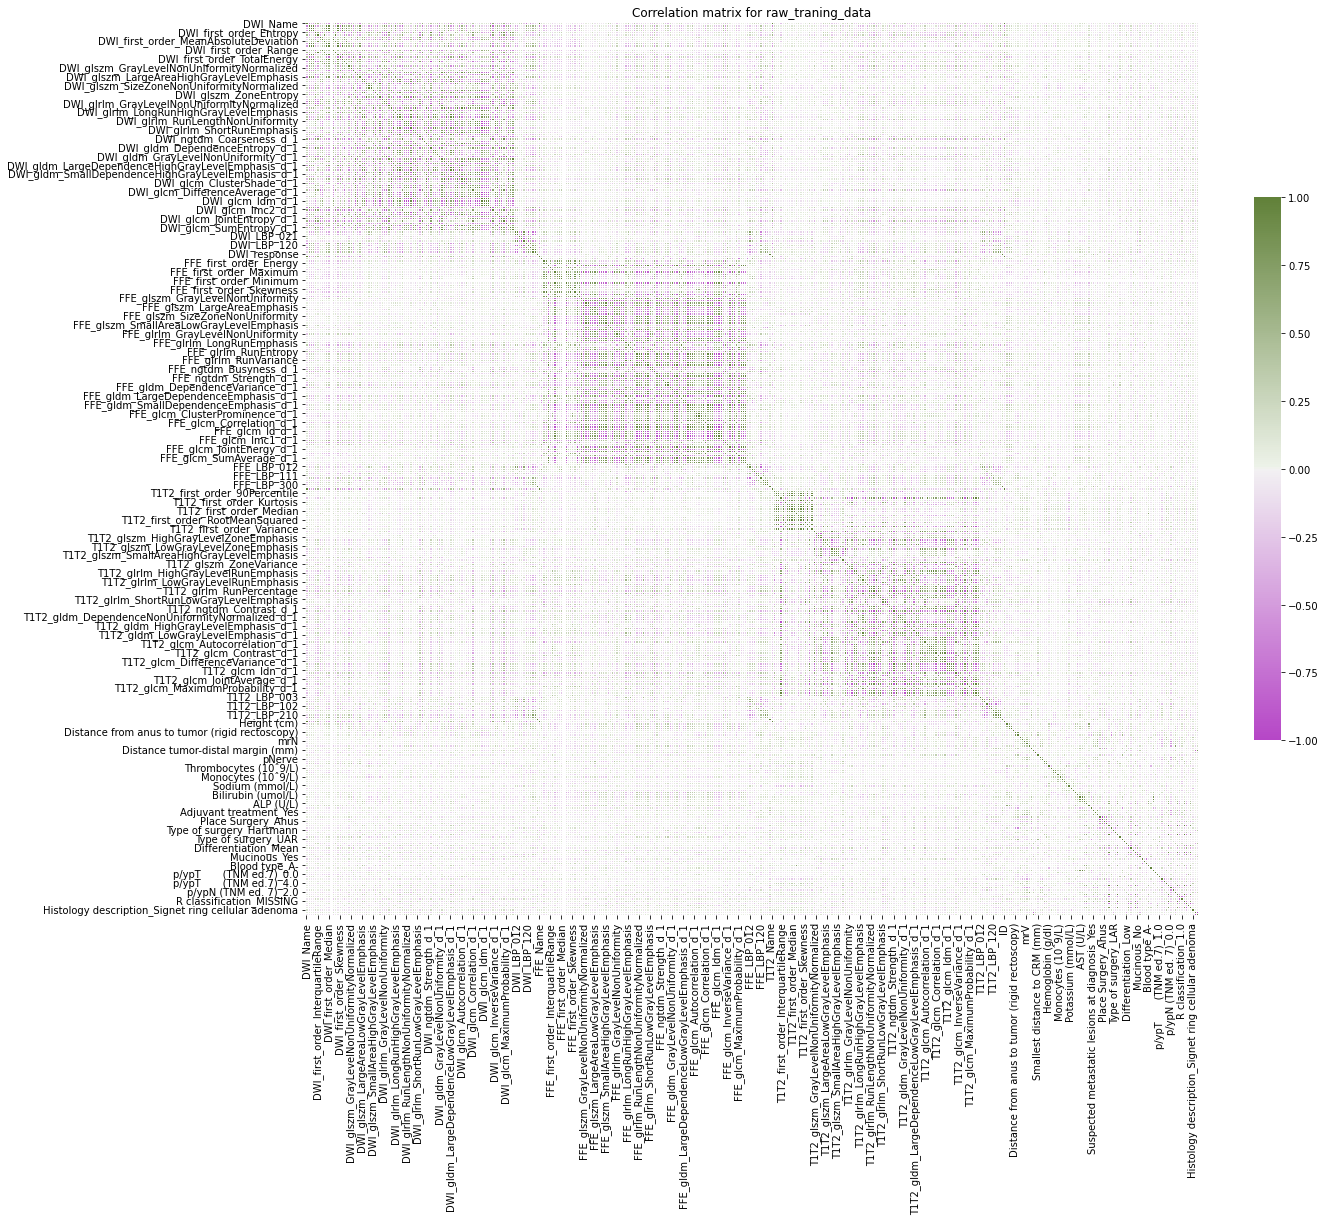

In [62]:
# Correlation matrix to inspect features.
corr = grand_data.corr()
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(300, 110, as_cmap=True)
plt.title('Correlation matrix for raw_traning_data')
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

#### Repeated Straified K-fold for RENT

In [66]:
# Set X and y from the full dataset. Removing duplicated IDs and responses.

X = grand_data.copy(deep=True)
X.drop(['ID', 
        'DWI_Name', 'DWI_response', 
        'FFE_Name', 'FFE_response', 
        'T1T2_Name', 'T1T2_response'], 
       axis=1, inplace=True)
y = FFE_RENT['FFE_response']

count = 0
train_predicted_objects = []
feature_count = dict.fromkeys(X.columns, 0)

tau1_values = [0.1, 0.3, 0.5, 0.75, 1] #len5
tau2_values = [0.1, 0.3, 0.5, 0.75, 1] #len5
tau3_values = [0.995, 0.999] #len2

RF_max_depth = [100, 300, 600] # len3
RF_criterion = ['gini', 'entropy'] # len2

## logistic regression
LR_penalties = ['l1', 'l2', 'elasticnet'] # len3
LR_C_params = [0.1, 0.5, 1, 5] # len4

# Define a range of regularisation parameters C for elastic net. A minimum of at least one value is required.
# Define a reange of l1-ratios for elastic net.  A minimum of at least one value is required.
C_parameters = [[0.1], [0.5], [1], [5], [10]] # len5
l1ratio_parameters = [[0.1], [0.25], [0.5], [0.75], [0.9]] # len5
# C and L1 parameters MUST be lists, so I assign each element as a 1-element list.

result_dict = {}
rs = 1337

for C in C_parameters:
    for l1 in l1ratio_parameters:
        
        # Setting up repeated straitifed kfold-object:
        splits = 4
        repeats = 5
        kfold = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=rs).split(X,y)
        rs += 1

        for train, test in kfold:
            count += 1
            print('RENT, C and l1 number', count, C, l1)

            kfold_RENT_model = RENT.RENT_Classification(
                                 data=X.iloc[train], 
                                 target=y.iloc[train], 
                                 feat_names=X.columns, 
                                 C=C, 
                                 l1_ratios=l1,
                                 autoEnetParSel=False,
                                 poly='OFF',
                                 testsize_range=(0.25,0.25),
                                 scoring='mcc',
                                 classifier='logreg',
                                 K=100,
                                 random_state=0,
                                 verbose=1)

            kfold_RENT_model.train()

            # Register %inaccurate predictions on trainset
            train_predicted_series = kfold_RENT_model.get_summary_objects()
            train_predicted_objects.append(train_predicted_series['% incorrect'])

            # The tau1-tau2-tau3 matrix
            for index1, tau1 in enumerate(tau1_values): # 2 tau1 values [0.3, 0.6]
                for index2, tau2 in enumerate(tau2_values): # 2 tau2 values [0.3, 0.6]
                    for index3, tau3 in enumerate(tau3_values): # 2 tau3 values [0.995, 0.999]
                        selected_features = kfold_RENT_model.select_features(tau_1_cutoff=tau1,
                                                                             tau_2_cutoff=tau2, 
                                                                             tau_3_cutoff=tau3)

                        feature_count = 0
                        feature_count = dict.fromkeys(X.columns, 0)
                        
                        # Register how often each feature is selected for this tau1-tau2-tau3 combination
                        for feature in X.columns[selected_features]:
                            feature_count[feature] += 1
                        
                        if X.columns[selected_features].any(): # only do ML and add values if there are any features left 
                            ## -- ##
                            ## Random Forest Training and Prediction:
                            ## -- ##
                            
                            RF_Acc_total = 0
                            RF_MCC_total = 0
                            RF_F1pos_total = 0
                            RF_F1neg_total = 0
                            RF_AUC_total = 0
                            
                            RF_Acc_train_total = 0
                            RF_MCC_train_total = 0
                            RF_F1pos_train_total = 0
                            RF_F1neg_train_total = 0
                            RF_AUC_train_total = 0
                            
                            for max_depth in RF_max_depth: # 3 max depths
                                for criterion in RF_criterion: # 2 criterions
                                    # Train RF model on selected features with specified hyperparameters:

                                    RENT_pipe_RF = make_pipeline(StandardScaler(),
                                                                 RandomForestClassifier(
                                                                     max_depth=max_depth,  
                                                                     criterion=criterion, 
                                                                     random_state=1337))
                                    RENT_pipe_RF.fit(X.iloc[train][X.columns[selected_features]], y.iloc[train])

                                    # Predict on validation set:
                                    y_pred = RENT_pipe_RF.predict(X.iloc[test][X.columns[selected_features]])
                                    RF_Acc = RENT_pipe_RF.score(X.iloc[test][X.columns[selected_features]], y.iloc[test].values)
                                    RF_Acc_total += RF_Acc
                                    RF_MCC = matthews_corrcoef(y_pred, y.iloc[test].values)
                                    RF_MCC_total += RF_MCC
                                    RF_F1pos = f1_score(y_pred, y.iloc[test].values)
                                    RF_F1pos_total += RF_F1pos
                                    RF_F1neg = f1_score(1-y_pred, 1-y.iloc[test].values)
                                    RF_F1neg_total += RF_F1neg 
                                    RF_AUC = roc_auc_score(y.iloc[test].values, y_pred)
                                    RF_AUC_total += RF_AUC
                                    
                                    # Train performance
                                    y_pred_train = RENT_pipe_RF.predict(X.iloc[train][X.columns[selected_features]])
                                    RF_Acc_train = RENT_pipe_RF.score(X.iloc[train][X.columns[selected_features]], y.iloc[train].values)
                                    RF_Acc_train_total += RF_Acc_train
                                    RF_MCC_train = matthews_corrcoef(y_pred_train, y.iloc[train].values)
                                    RF_MCC_train_total += RF_MCC_train
                                    RF_F1pos_train = f1_score(y_pred_train, y.iloc[train].values)
                                    RF_F1pos_train_total += RF_F1pos_train
                                    RF_F1neg_train = f1_score(1-y_pred_train, 1-y.iloc[train].values)
                                    RF_F1neg_train_total += RF_F1neg_train
                                    RF_AUC_train = roc_auc_score(y.iloc[train].values, y_pred_train) 
                                    RF_AUC_train_total += RF_AUC_train

                            
                            # Calculate avg performance over all the different hyperparameter combinations
                            RF_number = len(RF_max_depth)*len(RF_criterion)
                            RF_Acc_avg = RF_Acc_total/(RF_number)
                            RF_MCC_avg = RF_MCC_total/(RF_number)
                            RF_F1pos_avg = RF_F1pos_total/(RF_number)
                            RF_F1neg_avg = RF_F1neg_total/(RF_number)
                            RF_AUC_avg = RF_AUC_total/(RF_number)
                            
                            RF_Acc_avg_train = RF_Acc_train_total/(RF_number)
                            RF_MCC_avg_train = RF_MCC_train_total/(RF_number)
                            RF_F1pos_avg_train = RF_F1pos_train_total/(RF_number)
                            RF_F1neg_avg_train = RF_F1neg_train_total/(RF_number)
                            RF_AUC_avg_train = RF_AUC_train_total/(RF_number)
                            
                            
                            ## -- ##
                            ## Logistic regression Training and Prediction: ##
                            ## -- ##
                            LR_Acc_total = 0
                            LR_MCC_total = 0
                            LR_F1pos_total = 0
                            LR_F1neg_total = 0
                            LR_AUC_total = 0
                            
                            LR_Acc_train_total = 0
                            LR_MCC_train_total = 0
                            LR_F1pos_train_total = 0
                            LR_F1neg_train_total = 0
                            LR_AUC_train_total = 0

                            
                            for C_LR in LR_C_params:
                                for penalty in LR_penalties:
                                    # Train LogReg on training set with RENT's selected features
                                    RENT_pipe_LR = make_pipeline(StandardScaler(),
                                                                 LogisticRegression(
                                                                     C=C_LR,  
                                                                     penalty=penalty,
                                                                     solver='saga',
                                                                     l1_ratio=0.5,
                                                                     random_state=1337))
                                    RENT_pipe_LR.fit(X.iloc[train][X.columns[selected_features]], y.iloc[train])

                                    # Predict on validation set:
                                    y_pred = RENT_pipe_LR.predict(X.iloc[test][X.columns[selected_features]])
                                    LR_Acc = RENT_pipe_LR.score(X.iloc[test][X.columns[selected_features]], y.iloc[test].values)
                                    LR_Acc_total += LR_Acc
                                    LR_MCC = matthews_corrcoef(y_pred, y.iloc[test].values)
                                    LR_MCC_total += LR_MCC
                                    LR_F1pos = f1_score(y_pred, y.iloc[test].values)
                                    LR_F1pos_total += LR_F1pos
                                    LR_F1neg = f1_score(1-y_pred, 1-y.iloc[test].values)
                                    LR_F1neg_total += LR_F1neg  
                                    LR_AUC = roc_auc_score(y.iloc[test].values, y_pred)
                                    LR_AUC_total += LR_AUC
                                    
                                    # Train performance
                                    y_pred_train = RENT_pipe_LR.predict(X.iloc[train][X.columns[selected_features]])
                                    LR_Acc_train = RENT_pipe_LR.score(X.iloc[train][X.columns[selected_features]], y.iloc[train].values)
                                    LR_Acc_train_total += LR_Acc_train
                                    LR_MCC_train = matthews_corrcoef(y_pred_train, y.iloc[train].values)
                                    LR_MCC_train_total += LR_MCC_train
                                    LR_F1pos_train = f1_score(y_pred_train, y.iloc[train].values)
                                    LR_F1pos_train_total += LR_F1pos_train
                                    LR_F1neg_train = f1_score(1-y_pred_train, 1-y.iloc[train].values)
                                    LR_F1neg_train_total += LR_F1neg_train
                                    LR_AUC_train = roc_auc_score(y.iloc[train].values, y_pred_train) 
                                    LR_AUC_train_total += LR_AUC_train
                            
                            # Calculate avg performance over all the different hyperparameter combinations
                            LR_number = len(LR_C_params)*len(LR_penalties)
                            LR_Acc_avg = LR_Acc_total/(LR_number)
                            LR_MCC_avg = LR_MCC_total/(LR_number)
                            LR_F1pos_avg = LR_F1pos_total/(LR_number)
                            LR_F1neg_avg = LR_F1neg_total/(LR_number)
                            LR_AUC_avg = LR_AUC_total/(LR_number)
                            
                            LR_Acc_avg_train = LR_Acc_train_total/(LR_number)
                            LR_MCC_avg_train = LR_MCC_train_total/(LR_number)
                            LR_F1pos_avg_train = LR_F1pos_train_total/(LR_number)
                            LR_F1neg_avg_train = LR_F1neg_train_total/(LR_number)
                            LR_AUC_avg_train = LR_AUC_train_total/(LR_number)
                            
                            # This indent has access to: C', l1', train/test', tau1', tau2', tau3'.
                            repeat = count
                            key = (C[0], l1[0], repeat, tau1, tau2, tau3)

                            # Insert values into result-dictionary
                            result_dict[key] = {
                                                "test_performance": [
                                                    [RF_Acc_avg, RF_MCC_avg, RF_F1pos_avg, RF_F1neg_avg, RF_AUC_avg],
                                                    [LR_Acc_avg, LR_MCC_avg, LR_F1pos_avg, LR_F1neg_avg, LR_AUC_avg]], # test performance
                                                "features_selected": feature_count,
                                                "train_performance": [[RF_Acc_avg_train, RF_MCC_avg_train, 
                                                                       RF_F1pos_avg_train, RF_F1neg_avg_train, RF_AUC_avg_train],
                                                                     [LR_Acc_avg_train, LR_MCC_avg_train, 
                                                                      LR_F1pos_avg_train,LR_F1neg_avg_train,LR_AUC_avg_train]], 
                                                "summary_objects": kfold_RENT_model.get_summary_objects(), # (tau-independent)
                                                "summary_criteria": kfold_RENT_model.get_summary_criteria(),
                                                "train_samples": train,
                                                "test_samples": test
                                               }
                        
                        else: 
                            print('no features were selected for this [c,l1,tau1,tau2,tau3]-parameter combination')
            print('\n')


RENT, C and l1 number 1 [0.1] [0.1]
data dimension: (60, 396)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension: (60,)
regularization parameters C: [0.1]
elastic net l1_ratios: [0.1]
poly: OFF
number of models in ensemble: 100
random state: 0
verbose: 1
classifier: logreg
scoring: mcc


RENT, C and l1 number 2 [0.1] [0.1]
data dimension: (61, 396)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension: (61,)
regularization parameters C: [0.1]
elastic net l1_ratios: [0.1]
poly: OFF
number of models in ensemble: 100
random state: 0
verbose: 1
classifier: logreg
scoring: mcc


RENT, C and l1 number 3 [0.1] [0.1]
data dimension: (61, 396)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension: (61,)
regularization parameters C: [0.1]
elastic net l1_ratios: [0.1]
poly: OFF
number of models in ensemble: 100
random state: 0
verbose: 1
classifier: logreg
scoring: mcc


RENT, C and l1 number 4 [0.1] [0.1]
data dimension: (61, 396)  data type: <class 'pan

KeyboardInterrupt: 

In [73]:
# Write 
#with open('result_dict1.pickle', 'wb') as handle:
#    pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [74]:
# Looking at 1 object
result_dict[0.1, 0.1, 1, 0.75, 0.75, 0.995]

{'test_performance': [[0.7142857142857141,
   0.41045042487741595,
   0.6470588235294118,
   0.7599999999999999,
   0.7091346153846154],
  [0.6309523809523808,
   0.2560396442181436,
   0.5514364641493124,
   0.6789221706163237,
   0.6278044871794871]],
 'features_selected': {'DWI_first_order_10Percentile': 0,
  'DWI_first_order_90Percentile': 0,
  'DWI_first_order_Energy': 0,
  'DWI_first_order_Entropy': 0,
  'DWI_first_order_InterquartileRange': 1,
  'DWI_first_order_Kurtosis': 0,
  'DWI_first_order_Maximum': 0,
  'DWI_first_order_MeanAbsoluteDeviation': 0,
  'DWI_first_order_Mean': 0,
  'DWI_first_order_Median': 0,
  'DWI_first_order_Minimum': 0,
  'DWI_first_order_Range': 0,
  'DWI_first_order_RobustMeanAbsoluteDeviation': 1,
  'DWI_first_order_RootMeanSquared': 0,
  'DWI_first_order_Skewness': 0,
  'DWI_first_order_TotalEnergy': 0,
  'DWI_first_order_Uniformity': 0,
  'DWI_first_order_Variance': 1,
  'DWI_glszm_GrayLevelNonUniformity': 0,
  'DWI_glszm_GrayLevelNonUniformityNormali

In [71]:
# Ensuring that the different pipeline-objects have different IDs.
for C_LR in LR_C_params:
    for penalty in LR_penalties:
        RENT_pipe_LR = make_pipeline(StandardScaler(),
                                     LogisticRegression(
                                         C=C_LR,  
                                         penalty=penalty,
                                         solver='saga',
                                         l1_ratio=0.5,
                                         random_state=1337))
        RENT_pipe_LR.fit(X.iloc[train][X.columns[selected_features]], y.iloc[train])
        print(id(RENT_pipe_LR))

2233904349440
2233904349824
2233904349344
2233904349488
2233904349776
2233904350736
2233904351984
2233904350928
2233904351648
2233904349872
2233904351600
2233904350736


In [471]:
# Write
#with open('result_dict.pickle', 'wb') as handle:
#    pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [81]:
# Read
with open('result_dict.pickle', 'rb') as handle:
    result_dict = pickle.load(handle)

In [75]:
# Read
with open('result_dict1.pickle', 'rb') as handle:
    result_dict1 = pickle.load(handle)

In [82]:
# Calculate avg accuracy
breakpoint = 0
total_accuracy = [0,0,0,0,0]

for key in result_dict1:
    for index, RF_performance in enumerate(result_dict1[key]['test_performance'][0]):
        total_accuracy[index] += RF_performance
    breakpoint += 1
    if breakpoint > 25000:
        break

avg_accuracy_RF = [x / breakpoint for x in total_accuracy]
print('number of models counted:', breakpoint)
print('Accuracy, MCC, F1pos, F1neg, AUC')
print('total avg performance:', avg_accuracy_RF)

number of models counted: 21878
Accuracy, MCC, F1pos, F1neg, AUC
total avg performance: [0.6797851396706356, 0.2666370687448224, 0.450464649278335, 0.7688169177278156, 0.6159338807161652]


In [83]:
result_dict[0.1, 0.1, 1, 0.75, 0.75, 0.995]['test_performance'][0]

[0.7619047619047619,
 0.5095246653650681,
 0.7058823529411765,
 0.7999999999999999,
 0.7596153846153846]

In [84]:
# find best performance across different k-folds
breakpoint = 0
kfold_avg = []
total_accuracy = [0,0,0,0,0]
rents = 25000/(25) # 1000
breakpoint = 20 
dividend = 0

for i, key in enumerate(result_dict):
    dividend += 1
    for index, RF_performance in enumerate(result_dict[key]['test_performance'][0]):
        total_accuracy[index] += RF_performance
    if (key[2]%breakpoint == 0) and (key[3:] == (1,1,0.999)):
        avg_accuracy_RF = [x / dividend for x in total_accuracy]
        print(key, avg_accuracy_RF)
        total_accuracy = [0,0,0,0,0]
        dividend = 0 
                

(0.1, 0.1, 20, 1, 1, 0.999) [0.6858797619047616, 0.2804788652362224, 0.45860559138573787, 0.7731178461450668, 0.6213691620879118]
(0.1, 0.25, 40, 1, 1, 0.999) [0.6914678571428556, 0.2835701234902444, 0.4590959312746108, 0.7805424124837973, 0.6237833104395616]
(0.1, 0.5, 60, 1, 1, 0.999) [0.6846107142857174, 0.28376804038309156, 0.4738310671698466, 0.7680922397206306, 0.6250219780219786]
(0.1, 0.75, 80, 1, 1, 0.999) [0.7337880952380996, 0.390133538847648, 0.5280651364158723, 0.8110768254044494, 0.6698794642857182]
(0.1, 0.9, 100, 1, 1, 0.999) [0.7323392857142901, 0.38256500794128184, 0.5110856886577503, 0.8122133062225413, 0.6644835164835202]
(0.5, 0.1, 120, 1, 1, 0.999) [0.6848607142857112, 0.2789362987625602, 0.4452118059829749, 0.7735087425941126, 0.6160353708791225]
(0.5, 0.25, 140, 1, 1, 0.999) [0.692278571428569, 0.29322535546125955, 0.4471623894079802, 0.7812949651034004, 0.6206943681318665]
(0.5, 0.5, 160, 1, 1, 0.999) [0.692916666666667, 0.2818638027653214, 0.4360070365092439, 

In [85]:
# find best RF TRAIN performance across different k-folds
breakpoint = 0
kfold_avg = []
total_accuracy = [0,0,0,0,0]
rents = 25000/(25)
breakpoint = 20 
dividend = 0

for i, key in enumerate(result_dict):
    dividend += 1
    for index, RF_performance in enumerate(result_dict[key]['train_performance'][0]):
        total_accuracy[index] += RF_performance
    if (key[2]%breakpoint == 0) and (key[3:] == (1,1,0.999)):
        avg_accuracy_RF = [x / dividend for x in total_accuracy]
        print(key, avg_accuracy_RF)
        total_accuracy = [0,0,0,0,0]
        dividend = 0 

KeyError: 'train_performance'

In [86]:
performancelist = []
interval = np.arange(0,500)
for number in interval:
    for i, key in enumerate(result_dict1):
        if (key[2] == number):
            performancelist.append(result_dict1[key]['train_performance'][1][4])
statistics.stdev(performancelist)

0.10510170632554074

In [87]:
for i, key in enumerate(result_dict):
    if (key[2] == (202)):
        print(key, result_dict[key]['test_performance'][0])

(1, 0.1, 202, 0.1, 0.1, 0.995) [0.7250000000000001, 0.349106743373158, 0.47272727272727266, 0.8137931034482758, 0.6401098901098902]
(1, 0.1, 202, 0.1, 0.1, 0.999) [0.7000000000000001, 0.2788995520575486, 0.39999999999999997, 0.8000000000000002, 0.6043956043956044]
(1, 0.1, 202, 0.1, 0.3, 0.995) [0.7250000000000001, 0.349106743373158, 0.47272727272727266, 0.8137931034482758, 0.6401098901098902]
(1, 0.1, 202, 0.1, 0.3, 0.999) [0.6749999999999999, 0.21807113878291826, 0.38181818181818183, 0.7793103448275862, 0.5851648351648351]
(1, 0.1, 202, 0.1, 0.5, 0.995) [0.6999999999999998, 0.28827833009852755, 0.45454545454545453, 0.7931034482758621, 0.6208791208791209]
(1, 0.1, 202, 0.1, 0.5, 0.999) [0.6999999999999998, 0.28827833009852755, 0.45454545454545453, 0.7931034482758621, 0.6208791208791209]
(1, 0.1, 202, 0.1, 0.75, 0.995) [0.725, 0.36096385051158436, 0.5227272727272727, 0.8066502463054186, 0.6565934065934067]
(1, 0.1, 202, 0.1, 0.75, 0.999) [0.725, 0.36096385051158436, 0.5227272727272727,

In [88]:
summar_obj_df = pd.DataFrame()
breakpoint = 1
for i, key in enumerate(result_dict1):
    summar_obj_df = summar_obj_df.add(result_dict1[key]['summary_objects'], axis='index', fill_value=0)

print(summar_obj_df)
summar_obj_df['% incorrect'] = summar_obj_df['% incorrect'].div(16408.5)
summar_obj_df['incorrect_ratio'] = summar_obj_df['# incorrect'].div(summar_obj_df['# test'])

      # test    class  # incorrect   % incorrect
0   481396.0  16296.0     330884.0  1.119064e+06
1   460174.0  16326.0     312216.0  1.108758e+06
2   471134.0      0.0     122424.0  4.221517e+05
3   403160.0  16402.0      34750.0  1.394048e+05
4   411978.0  16286.0      13080.0  5.347091e+04
..       ...      ...          ...           ...
76  406810.0      0.0     107836.0  4.369507e+05
77  423590.0      0.0     349072.0  1.338472e+06
78  478080.0  16524.0      17036.0  5.947383e+04
79  493668.0  16588.0     157934.0  5.300861e+05
80  477166.0      0.0      13302.0  4.586897e+04

[81 rows x 4 columns]


In [89]:
print(summar_obj_df.sort_values(by=['incorrect_ratio'], ascending=False).head(15))

      # test    class  # incorrect  % incorrect  incorrect_ratio
24  390498.0  16236.0     389666.0    98.739536         0.997869
16  341220.0  16240.0     330288.0    95.661513         0.967962
21  375088.0  16324.0     354606.0    94.015604         0.945394
51  463246.0  16364.0     436380.0    93.926090         0.942005
32  421044.0  16502.0     395712.0    94.634292         0.939835
72  492480.0  16280.0     437638.0    88.224857         0.888641
64  440710.0  16382.0     384148.0    86.798676         0.871657
10  375318.0  16304.0     326944.0    86.636212         0.871112
60  376748.0      0.0     325094.0    84.797595         0.862895
77  423590.0      0.0     349072.0    81.571851         0.824080
63  437240.0  16476.0     356222.0    81.769461         0.814706
37  470086.0  16406.0     375400.0    79.949785         0.798577
33  439008.0  16564.0     345258.0    79.321213         0.786450
19  463502.0      0.0     358402.0    78.519879         0.773248
14  468424.0      0.0    

In [90]:
# find best performance for a chosen parameter

total_performance = [0,0,0,0,0]
rents = 25000/(25)
counter = 0
#C_parameters = [[0.1], [0.5], [1], [5], [10]] # len5
#l1ratio_parameters = [[0.1], [0.25], [0.5], [0.75], [0.9]] # len5
#tau1_values = [0.1, 0.3, 0.5, 0.75, 1] #len5
#tau2_values = [0.1, 0.3, 0.5, 0.75, 1] #len5
#tau3_values = [0.995, 0.999] #len2

for param in tau1_values:
    for i, key in enumerate(result_dict1):
        for index, RF_performance in enumerate(result_dict1[key]['test_performance'][1]):
            if key[4] == param:
                total_performance[index] += RF_performance
                counter += 1
    counter = counter/5
    print(counter)
    avg_accuracy_RF = [x / counter for x in total_performance]
    counter = 0
    print('Performance for Tau1 and Tau2 = ', param,  avg_accuracy_RF)
    total_performance = [0,0,0,0,0]

4638.0
Performance for Tau1 and Tau2 =  0.1 [0.669049458578886, 0.2517510346087433, 0.45191024285832954, 0.7548286584362549, 0.6131238799920041]
4632.0
Performance for Tau1 and Tau2 =  0.3 [0.6693648137867659, 0.25231511841956655, 0.45181598992286287, 0.755111604455128, 0.613285574708825]
4624.0
Performance for Tau1 and Tau2 =  0.5 [0.6710747411709789, 0.25510402305175717, 0.4521033037046533, 0.7571135726732383, 0.6142067792897641]
4564.0
Performance for Tau1 and Tau2 =  0.75 [0.6728174603174567, 0.258862286403476, 0.4536619944324969, 0.7588063656401367, 0.6154594314719689]
3420.0
Performance for Tau1 and Tau2 =  1 [0.6816607490949637, 0.25735976712349706, 0.41752006030211425, 0.774347362958831, 0.610093944797891]


In [91]:
# find best LOGREG performance across different k-folds
breakpoint = 0
kfold_avg = []
total_accuracy = [0,0,0,0,0]
rents = 25000/(25)

for i, key in enumerate(result_dict):
    for index, LR_performance in enumerate(result_dict[key]['test_performance'][1]):
        total_accuracy[index] += LR_performance
        if (i+1)%rents == 0:
            avg_accuracy_LR = [x / rents for x in total_accuracy]
            print(key, avg_accuracy_LR)
            total_accuracy = [0,0,0,0,0]
            break

(0.1, 0.1, 20, 1, 1, 0.999) [0.6801468253968231, 0.26779058916228043, 0.443371511308896, 0.7655671368831671, 0.6165585508241749]
(0.1, 0.25, 40, 1, 1, 0.999) [0.6928994047619057, 0.29666697445898443, 0.46265181747933215, 0.7765749237123839, 0.6284767055860789]
(0.1, 0.5, 60, 1, 1, 0.999) [0.7079936507936547, 0.3232968367502684, 0.474989987729846, 0.791371750709958, 0.6400064102564095]
(0.1, 0.75, 80, 1, 1, 0.999) [0.738910714285721, 0.3903470700007549, 0.5021927077537741, 0.8188813585118832, 0.6645358859890134]
(0.1, 0.9, 100, 1, 1, 0.999) [0.7432930555555631, 0.3992135594505031, 0.503971768060369, 0.823094483843106, 0.6680921474359022]
(0.5, 0.1, 120, 1, 1, 0.999) [0.6712908730158725, 0.25485082069760556, 0.4455863575551247, 0.7560759288206383, 0.611892742673995]
(0.5, 0.25, 140, 1, 1, 0.999) [0.6804277777777763, 0.27069732543934766, 0.4382017930691886, 0.7664142656138164, 0.6148618360805856]
(0.5, 0.5, 160, 1, 1, 0.999) [0.683214484126986, 0.27058796347651176, 0.439429334677476, 0.77

In [94]:
breakpoint = 0
print(' C,   l1, RENT, t1, t2,  t3')
for key in result_dict:
    print(breakpoint, key)
    breakpoint += 1
    if breakpoint > 100:
        break
print(len(result_dict.keys()))


 C,   l1, RENT, t1, t2,  t3
0 (0.1, 0.1, 1, 0.1, 0.1, 0.995)
1 (0.1, 0.1, 1, 0.1, 0.1, 0.999)
2 (0.1, 0.1, 1, 0.1, 0.3, 0.995)
3 (0.1, 0.1, 1, 0.1, 0.3, 0.999)
4 (0.1, 0.1, 1, 0.1, 0.5, 0.995)
5 (0.1, 0.1, 1, 0.1, 0.5, 0.999)
6 (0.1, 0.1, 1, 0.1, 0.75, 0.995)
7 (0.1, 0.1, 1, 0.1, 0.75, 0.999)
8 (0.1, 0.1, 1, 0.1, 1, 0.995)
9 (0.1, 0.1, 1, 0.1, 1, 0.999)
10 (0.1, 0.1, 1, 0.3, 0.1, 0.995)
11 (0.1, 0.1, 1, 0.3, 0.1, 0.999)
12 (0.1, 0.1, 1, 0.3, 0.3, 0.995)
13 (0.1, 0.1, 1, 0.3, 0.3, 0.999)
14 (0.1, 0.1, 1, 0.3, 0.5, 0.995)
15 (0.1, 0.1, 1, 0.3, 0.5, 0.999)
16 (0.1, 0.1, 1, 0.3, 0.75, 0.995)
17 (0.1, 0.1, 1, 0.3, 0.75, 0.999)
18 (0.1, 0.1, 1, 0.3, 1, 0.995)
19 (0.1, 0.1, 1, 0.3, 1, 0.999)
20 (0.1, 0.1, 1, 0.5, 0.1, 0.995)
21 (0.1, 0.1, 1, 0.5, 0.1, 0.999)
22 (0.1, 0.1, 1, 0.5, 0.3, 0.995)
23 (0.1, 0.1, 1, 0.5, 0.3, 0.999)
24 (0.1, 0.1, 1, 0.5, 0.5, 0.995)
25 (0.1, 0.1, 1, 0.5, 0.5, 0.999)
26 (0.1, 0.1, 1, 0.5, 0.75, 0.995)
27 (0.1, 0.1, 1, 0.5, 0.75, 0.999)
28 (0.1, 0.1, 1, 0.5, 1, 0.995)


In [95]:
# Counting 1 feature per RENT
breakpoint = 0
counter = 0
for i, (key, value) in enumerate(result_dict.items()):
    counter += result_dict[key]['features_selected']['Suspected metastatic lesions at diagnosis_Yes']   
    if (i+1)%1000 == 0:
        print(counter)
        counter = 0
    
    breakpoint += 1
    if breakpoint > 25000:
        break


892
838
706
584
424
910
892
820
738
692
910
892
838
702
692
946
910
892
856
788
982
928
892
892
856


In [96]:
# Counting features per Tau1-2
tau12_dict_counter = {}
breakpoint = 0
counter = 0
TAU = 0.75

for key in result_dict1:
    feature_dictionary = result_dict1[key]['features_selected']
    for feature_key in feature_dictionary:
        if ((key[3] == TAU) and (key[4] == TAU)):
            if feature_key not in tau12_dict_counter:    
                tau12_dict_counter[feature_key] = feature_dictionary[feature_key]
            elif feature_key in tau12_dict_counter:
                tau12_dict_counter[feature_key] += feature_dictionary[feature_key]
            counter += 1
    breakpoint += 1
    if breakpoint > 25000:
        break

print(breakpoint, counter/(396))
sorteddict = {k: v for k, v in sorted(tau12_dict_counter.items(), key=lambda item: item[1], reverse=True)}
sorteddict

21878 970.0


{'Suspected metastatic lesions at diagnosis_Yes': 956,
 'Adjuvant treatment_Yes': 806,
 'Type of surgery_Hartmann': 806,
 'FFE_LBP_012': 604,
 'MR distance from anus to tumor': 602,
 'FFE_glcm_ClusterProminence_d_1': 582,
 'R classification_0.0': 574,
 'CEA (ug/L)': 572,
 'DWI_first_order_InterquartileRange': 550,
 'DWI_glcm_MCC_d_1': 534,
 'FFE_first_order_Median': 530,
 'FFE_glcm_ClusterShade_d_1': 508,
 'Lymphocytes (10ˆ9/L)': 506,
 'Blood type_B+': 504,
 'p/ypT       (TNM ed.7)_0.0': 504,
 'FFE_first_order_90Percentile': 490,
 'FFE_LBP_102': 488,
 'p/ypT       (TNM ed.7)_4.0': 486,
 'Type of surgery_UAR': 466,
 'p/ypN (TNM ed. 7)_0.0': 464,
 'DWI_LBP_300': 450,
 'DWI_first_order_RobustMeanAbsoluteDeviation': 446,
 'Place Surgery_MISSING': 446,
 'Type of surgery_MISSING': 446,
 'p/ypT       (TNM ed.7)_MISSING': 446,
 'p/ypN (TNM ed. 7)_MISSING': 446,
 'R classification_MISSING': 446,
 'Leukocytes (10ˆ9/L)': 410,
 'mrT    (TNM ed.7)': 408,
 'FFE_first_order_Mean': 402,
 'FFE_glcm_Clu

In [97]:
# Counting features overall
tau12_dict_counter = {}
breakpoint = 0
counter = 0

for key in result_dict1:
    feature_dictionary = result_dict1[key]['features_selected']
    for feature_key in feature_dictionary:
        if feature_key not in tau12_dict_counter:    
            tau12_dict_counter[feature_key] = feature_dictionary[feature_key]
        elif feature_key in tau12_dict_counter:
            tau12_dict_counter[feature_key] += feature_dictionary[feature_key]
        counter += 1
    breakpoint += 1
    if breakpoint > 25000:
        break

print(breakpoint, counter/(396))
sorteddict = {k: v for k, v in sorted(tau12_dict_counter.items(), key=lambda item: item[1], reverse=True)}
sorteddict

21878 21878.0


{'Suspected metastatic lesions at diagnosis_Yes': 20294,
 'Type of surgery_Hartmann': 16322,
 'Adjuvant treatment_Yes': 16024,
 'CEA (ug/L)': 13488,
 'FFE_LBP_012': 13426,
 'MR distance from anus to tumor': 12255,
 'R classification_0.0': 12074,
 'FFE_glcm_ClusterProminence_d_1': 11654,
 'DWI_glcm_MCC_d_1': 11632,
 'DWI_first_order_InterquartileRange': 11599,
 'FFE_first_order_Median': 11285,
 'p/ypN (TNM ed. 7)_0.0': 11021,
 'Lymphocytes (10ˆ9/L)': 10893,
 'FFE_LBP_102': 10802,
 'p/ypT       (TNM ed.7)_4.0': 10581,
 'FFE_first_order_90Percentile': 10536,
 'p/ypT       (TNM ed.7)_0.0': 10508,
 'Blood type_B+': 10460,
 'Type of surgery_UAR': 10451,
 'FFE_glcm_ClusterShade_d_1': 10241,
 'DWI_first_order_RobustMeanAbsoluteDeviation': 10150,
 'Place Surgery_MISSING': 10012,
 'Type of surgery_MISSING': 10012,
 'p/ypT       (TNM ed.7)_MISSING': 10012,
 'p/ypN (TNM ed. 7)_MISSING': 10012,
 'R classification_MISSING': 10012,
 'DWI_LBP_300': 9794,
 'Leukocytes (10ˆ9/L)': 9760,
 'mrT    (TNM ed.

In [142]:
# Repeated analysis with only RF, but more in-depth.

X = grand_data.copy(deep=True)
X.drop(['ID', 
        'DWI_Name', 'DWI_response', 
        'FFE_Name', 'FFE_response', 
        'T1T2_Name', 'T1T2_response'], 
       axis=1, inplace=True)
y = FFE_RENT['FFE_response']

count = 0
train_predicted_objects = []
feature_count = dict.fromkeys(X.columns, 0)

tau1_values = [0.1, 0.3, 0.5, 0.75, 1] #len5
tau2_values = [0.1, 0.3, 0.5, 0.75, 1] #len5
tau3_values = [0.995, 0.999] #len2

RF_max_depth = [2, 5, 10] # len3
RF_criterion = ['gini', 'entropy'] # len2


C_parameters = [[0.1], [0.5], [1], [5], [10]] # len5
l1ratio_parameters = [[0.1], [0.25], [0.5], [0.75], [0.9]] # len5
# C and L1 parameters MUST be lists, so I assign each element as a 1-element list.

In [332]:
# Set X and y from the full dataset. Removing duplicated IDs and responses.
# Full dataset:

X = grand_data.copy(deep=True)
X.drop(['ID', 
        'DWI_Name', 'DWI_response', 
        'FFE_Name', 'FFE_response', 
        'T1T2_Name', 'T1T2_response'], 
       axis=1, inplace=True)
y = FFE_RENT['FFE_response']

count = 0
train_predicted_objects = []
feature_count = dict.fromkeys(X.columns, 0)

tau1_values = [0.1, 0.3, 0.5, 0.75, 1] #len5
tau2_values = [0.1, 0.3, 0.5, 0.75, 1] #len5
tau3_values = [0.995, 0.999] #len2

RF_max_depth = [2, 5, 10] # len3
RF_criterion = ['gini', 'entropy'] # len2


# Define a range of regularisation parameters C for elastic net. A minimum of at least one value is required.
# Define a reange of l1-ratios for elastic net.  A minimum of at least one value is required.
C_parameters = [[0.1], [0.5], [1], [5], [10]] # len5
l1ratio_parameters = [[0.1], [0.25], [0.5], [0.75], [0.9]] # len5
# C and L1 parameters MUST be lists, so I assign each element as a 1-element list.

result_dict_RF = {}
rs = 1337


for C in C_parameters:
    for l1 in l1ratio_parameters:
        
        # Setting up repeated straitifed kfold-object:
        splits = 4
        repeats = 5
        kfold = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=rs).split(X,y)
        rs += 1

        for train, test in kfold:
            count += 1
            print('RENT, C and l1 number', count, C, l1)

            kfold_RENT_model = RENT.RENT_Classification(
                                 data=X.iloc[train], 
                                 target=y.iloc[train], 
                                 feat_names=X.columns, 
                                 C=C, 
                                 l1_ratios=l1,
                                 autoEnetParSel=False,
                                 poly='OFF',
                                 testsize_range=(0.25,0.25),
                                 scoring='mcc',
                                 classifier='logreg',
                                 K=100,
                                 random_state=0,
                                 verbose=1)

            kfold_RENT_model.train()

            # Register %inaccurate predictions on trainset
            train_predicted_series = kfold_RENT_model.get_summary_objects()
            train_predicted_objects.append(train_predicted_series['% incorrect'])

            # The tau1-tau2-tau3 matrix
            for index1, tau1 in enumerate(tau1_values): 
                for index2, tau2 in enumerate(tau2_values): 
                    for index3, tau3 in enumerate(tau3_values):
                        selected_features = kfold_RENT_model.select_features(tau_1_cutoff=tau1,
                                                                             tau_2_cutoff=tau2, 
                                                                             tau_3_cutoff=tau3)

                        feature_count = 0
                        feature_count = dict.fromkeys(X.columns, 0)
                        
                        # Register how often each feature is selected for this tau1-tau2-tau3 combination
                        for feature in X.columns[selected_features]:
                            feature_count[feature] += 1
                        
                        if X.columns[selected_features].any(): # only do ML and add values if there are any features left 
                            ## -- ##
                            ## Random Forest Training and Prediction:
                            ## -- ##
                            
                            RF_Acc_total = 0
                            RF_MCC_total = 0
                            RF_F1pos_total = 0
                            RF_F1neg_total = 0
                            RF_AUC_total = 0
                            
                            RF_Acc_train_total = 0
                            RF_MCC_train_total = 0
                            RF_F1pos_train_total = 0
                            RF_F1neg_train_total = 0
                            RF_AUC_train_total = 0
                            
                            for max_depth in RF_max_depth: # 3 max depths
                                for criterion in RF_criterion: # 2 criterions
                                    # Train RF model on selected features with specified hyperparameters:

                                    RENT_pipe_RF = make_pipeline(StandardScaler(), # consider removing standardscaler
                                                                 RandomForestClassifier(
                                                                     max_depth=max_depth,  
                                                                     criterion=criterion, 
                                                                     random_state=1337))
                                    RENT_pipe_RF.fit(X.iloc[train][X.columns[selected_features]], y.iloc[train])

                                    # Predict on validation set:
                                    y_pred = RENT_pipe_RF.predict(X.iloc[test][X.columns[selected_features]])
                                    RF_Acc = RENT_pipe_RF.score(X.iloc[test][X.columns[selected_features]], y.iloc[test].values)
                                    RF_MCC = matthews_corrcoef(y_pred, y.iloc[test].values)
                                    RF_F1pos = f1_score(y_pred, y.iloc[test].values)
                                    RF_F1neg = f1_score(1-y_pred, 1-y.iloc[test].values)
                                    RF_AUC = roc_auc_score(y.iloc[test].values, y_pred)
                                    
                                    # Train performance
                                    y_pred_train = RENT_pipe_RF.predict(X.iloc[train][X.columns[selected_features]])
                                    RF_Acc_train = RENT_pipe_RF.score(X.iloc[train][X.columns[selected_features]], y.iloc[train].values)
                                    RF_MCC_train = matthews_corrcoef(y_pred_train, y.iloc[train].values)
                                    RF_F1pos_train = f1_score(y_pred_train, y.iloc[train].values)
                                    RF_F1neg_train = f1_score(1-y_pred_train, 1-y.iloc[train].values)
                                    RF_AUC_train = roc_auc_score(y.iloc[train].values, y_pred_train) 
                            
                                    # This indent has access to: C', l1', train/test', tau1', tau2', tau3', max_depth', criterion'.
                                    repeat = count
                                    key = (C[0], l1[0], repeat, tau1, tau2, tau3, max_depth, criterion)

                                    # Insert values into result-dictionary
                                    result_dict_RF[key] = {
                                                        "test_performance": [[RF_Acc, RF_MCC, RF_F1pos, RF_F1neg, RF_AUC]], # test performance
                                                        "features_selected": feature_count,
                                                        "train_performance": [[RF_Acc_train, RF_MCC_train, 
                                                                               RF_F1pos_train, RF_F1neg_train, RF_AUC_train]], 
                                                        "summary_objects": kfold_RENT_model.get_summary_objects(), # (tau-independent)
                                                        "summary_criteria": kfold_RENT_model.get_summary_criteria(),
                                                        "train_samples": train,
                                                        "test_samples": test
                                                       }
                        
                        else: 
                            print('no features were selected for this [c,l1,tau1,tau2,tau3]-parameter combination')
            print('\n')


RENT, C and l1 number 1 [0.1] [0.1]
data dimension: (60, 396)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension: (60,)
regularization parameters C: [0.1]
elastic net l1_ratios: [0.1]
poly: OFF
number of models in ensemble: 100
random state: 0
verbose: 1
classifier: logreg
scoring: mcc


RENT, C and l1 number 2 [0.1] [0.1]
data dimension: (61, 396)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension: (61,)
regularization parameters C: [0.1]
elastic net l1_ratios: [0.1]
poly: OFF
number of models in ensemble: 100
random state: 0
verbose: 1
classifier: logreg
scoring: mcc


RENT, C and l1 number 3 [0.1] [0.1]
data dimension: (61, 396)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension: (61,)
regularization parameters C: [0.1]
elastic net l1_ratios: [0.1]
poly: OFF
number of models in ensemble: 100
random state: 0
verbose: 1
classifier: logreg
scoring: mcc


RENT, C and l1 number 4 [0.1] [0.1]
data dimension: (61, 396)  data type: <class 'pan

In [98]:
# Read
with open('result_dict_RF.pickle', 'rb') as handle:
    result_dict_RF = pickle.load(handle)

In [381]:
# find best performance for a chosen parameter

total_performance = [0,0,0,0,0]
#C_parameters = [[0.1], [0.5], [1], [5], [10]] # len5
#l1ratio_parameters = [[0.1], [0.25], [0.5], [0.75], [0.9]] # len5
#tau1_values = [0.1, 0.3, 0.5, 0.75, 1] #len5
#tau2_values = [0.1, 0.3, 0.5, 0.75, 1] #len5
#tau3_values = [0.995, 0.999] #len2
#RF_max_depth = [2, 5, 10] # len3
#RF_criterion = ['gini', 'entropy'] # len2


dividend = 0

for c in C_parameters: 
    for l1ratio in l1ratio_parameters:
        for tau1 in tau1_values:
            for tau2 in tau2_values:
                for param in RF_max_depth:
                    for i, key in enumerate(result_dict_RF):
                        for index, RF_performance in enumerate(result_dict_RF[key]['test_performance'][0]):
                            if ((key[6] == param) and 
                                (key[0] == c[0]) and 
                                (key[1] == l1ratio[0]) and 
                                (key[3] == tau1) and 
                                (key[4] == tau2)):
                                total_performance[index] += RF_performance
                                dividend += 1/5
                    if dividend != 0:
                        avg_accuracy_RF = [x / dividend for x in total_performance]
                        print(dividend)
                        dividend = 0
                    print(c, l1ratio, tau1, tau2, param, avg_accuracy_RF)
                    total_performance = [0,0,0,0,0]


80.0000000000006
[0.1] [0.1] 0.1 0.1 2 [0.683511904761899, 0.25116312399965884, 0.3623660877521142, 0.7863951103548167, 0.5909941620879077]
80.0000000000006
[0.1] [0.1] 0.1 0.1 5 [0.6837202380952325, 0.264022381642814, 0.41625790059613255, 0.7799611617230093, 0.6046359890109843]
80.0000000000006
[0.1] [0.1] 0.1 0.1 10 [0.6836904761904705, 0.26213361818767417, 0.4131613096870417, 0.7805967632856825, 0.6035113324175777]
80.0000000000006
[0.1] [0.1] 0.1 0.3 2 [0.6841071428571376, 0.2558843681298593, 0.3860776029525998, 0.7841437965589739, 0.5970982142857097]
80.0000000000006
[0.1] [0.1] 0.1 0.3 5 [0.6832440476190422, 0.260617268638355, 0.4165756465756433, 0.7795111415512496, 0.6041552197802151]
80.0000000000006
[0.1] [0.1] 0.1 0.3 10 [0.678869047619042, 0.2505164799802764, 0.40084165834165525, 0.777465133471454, 0.596892170329666]
80.0000000000006
[0.1] [0.1] 0.1 0.5 2 [0.6964285714285662, 0.2877473951335954, 0.388366772116769, 0.7949158337002408, 0.6058894230769188]
80.0000000000006
[0.1

In [98]:
total_performance = [0,0,0,0,0]
dividend = 0

for c in C_parameters: 
    for l1ratio in l1ratio_parameters:
        for tau1 in tau1_values:
            for tau2 in tau2_values:
                for tau3 in tau3_values:
                    for depth in RF_max_depth:
                        for criterion in RF_criterion:
                            for i, key in enumerate(result_dict_RF):
                                for index, RF_performance in enumerate(result_dict_RF[key]['test_performance'][0]):
                                    if ((key[6] == depth) 
                                        and (key[0] == c[0]) 
                                        and (key[1] == l1ratio[0])
                                        and (key[3] == tau1) 
                                        and (key[4] == tau2)
                                        and (key[5] == tau3)
                                        and (key[7] == criterion)):
                                        total_performance[index] += RF_performance
                                        dividend += 1/5
                            if dividend != 0:
                                avg_accuracy_RF = [x / dividend for x in total_performance]
                                dividend = 0

                            if avg_accuracy_RF[0] > 0.7:
                                print(c, l1ratio, tau1, tau2, tau3, depth, criterion, avg_accuracy_RF)
                            total_performance = [0,0,0,0,0]


[0.1] [0.1] 0.1 0.5 0.995 2 entropy [0.7013095238095252, 0.3030572992965794, 0.4026803751803761, 0.7975908411871998, 0.6119848901098912]
[0.1] [0.1] 0.1 0.5 0.999 2 entropy [0.7013095238095252, 0.3030572992965794, 0.4026803751803761, 0.7975908411871998, 0.6119848901098912]
[0.1] [0.1] 0.1 0.75 0.995 2 gini [0.7033333333333348, 0.30803562737015516, 0.4239384226884236, 0.7960499584150877, 0.6212568681318692]
[0.1] [0.1] 0.1 0.75 0.995 2 entropy [0.7105952380952396, 0.3226187583580531, 0.42929972804972893, 0.8025086338392805, 0.6265796703296714]
[0.1] [0.1] 0.1 0.75 0.995 5 gini [0.7030952380952397, 0.2983505642407136, 0.46803252303252396, 0.7887757569337118, 0.637912087912089]
[0.1] [0.1] 0.1 0.75 0.995 10 gini [0.7033333333333349, 0.30009956013207384, 0.46522595052006904, 0.7895651908138019, 0.6371565934065945]
[0.1] [0.1] 0.1 0.75 0.999 2 gini [0.7033333333333348, 0.30803562737015516, 0.4239384226884236, 0.7960499584150877, 0.6212568681318692]
[0.1] [0.1] 0.1 0.75 0.999 2 entropy [0.71

In [99]:
for index, key in enumerate(result_dict_RF):
    if ((key[6] == 2) 
        and (key[0] == 10) 
        and (key[1] == 0.25) 
        and (key[3] == 1) 
        and (key[4] == 1) 
        and (key[5] == 0.995) 
        and (key[7] == 'entropy')):
        print(key, result_dict_RF[key]['test_performance'][0])

(10, 0.25, 421, 1, 1, 0.995, 2, 'entropy') [0.6666666666666666, 0.25215418055077093, 0.4615384615384615, 0.7586206896551724, 0.6105769230769231]
(10, 0.25, 422, 1, 1, 0.995, 2, 'entropy') [0.85, 0.6813851438692469, 0.7272727272727273, 0.896551724137931, 0.7857142857142857]
(10, 0.25, 423, 1, 1, 0.995, 2, 'entropy') [0.8, 0.5447047794019222, 0.6666666666666666, 0.8571428571428571, 0.7472527472527473]
(10, 0.25, 424, 1, 1, 0.995, 2, 'entropy') [0.7, 0.3126409456585232, 0.25, 0.8125000000000001, 0.5714285714285714]
(10, 0.25, 425, 1, 1, 0.995, 2, 'entropy') [0.8571428571428571, 0.7126096406869613, 0.7692307692307693, 0.896551724137931, 0.8125]
(10, 0.25, 426, 1, 1, 0.995, 2, 'entropy') [0.65, 0.2058790548922549, 0.4615384615384615, 0.7407407407407408, 0.5989010989010989]
(10, 0.25, 427, 1, 1, 0.995, 2, 'entropy') [0.7, 0.2788995520575487, 0.4, 0.8000000000000002, 0.6043956043956044]
(10, 0.25, 428, 1, 1, 0.995, 2, 'entropy') [0.6, 0.060522753266880246, 0.3333333333333333, 0.71428571428571

In [100]:
bestperformance = []
dict_counter = {}
breakpoint = 0

for index, key in enumerate(result_dict_RF):
    if ((key[6] == 2) 
        and (key[0] == 5) 
        and (key[1] == 0.1) 
        and (key[3] == 1) 
        and (key[4] == 0.5) 
        and (key[5] == 0.995) 
        and (key[7] == 'gini')):
        bestperformance.append(result_dict_RF[key]['train_performance'][0][0])
        
        print(result_dict_RF[key]['summary_criteria']['Adjuvant treatment_Yes'])
        
print(breakpoint, counter/(396))

#[5] [0.1] 1 0.5 0.995 2 gini [0.7579761904761919, 0.46809836578743114, 0.5666984404484415, 0.829473239779832, 0.6932348901098914]
#[5] [0.1] 1 0.5 0.999 2 gini [0.7579761904761919, 0.46809836578743114, 0.5666984404484415, 0.829473239779832, 0.6932348901098914]
#[5] [0.1] 1 0.75 0.995 2 gini [0.7579761904761919, 0.46809836578743114, 0.5666984404484415, 0.829473239779832, 0.6932348901098914]
#[5] [0.1] 1 0.75 0.999 2 gini [0.7579761904761919, 0.46809836578743114, 0.5666984404484415, 0.829473239779832, 0.6932348901098914]

tau_1    1.0
tau_2    1.0
tau_3    1.0
Name: Adjuvant treatment_Yes, dtype: float64
tau_1    1.0
tau_2    1.0
tau_3    1.0
Name: Adjuvant treatment_Yes, dtype: float64
tau_1    0.99
tau_2    0.99
tau_3    1.00
Name: Adjuvant treatment_Yes, dtype: float64
tau_1    1.0
tau_2    1.0
tau_3    1.0
Name: Adjuvant treatment_Yes, dtype: float64
tau_1    1.0
tau_2    1.0
tau_3    1.0
Name: Adjuvant treatment_Yes, dtype: float64
tau_1    1.0
tau_2    1.0
tau_3    1.0
Name: Adjuvant treatment_Yes, dtype: float64
tau_1    1.0
tau_2    1.0
tau_3    1.0
Name: Adjuvant treatment_Yes, dtype: float64
tau_1    1.0
tau_2    1.0
tau_3    1.0
Name: Adjuvant treatment_Yes, dtype: float64
tau_1    1.0
tau_2    1.0
tau_3    1.0
Name: Adjuvant treatment_Yes, dtype: float64
tau_1    1.0
tau_2    1.0
tau_3    1.0
Name: Adjuvant treatment_Yes, dtype: float64
tau_1    1.0
tau_2    1.0
tau_3    1.0
Name: Adjuvant treatment_Yes, dtype: float64
tau_1    1.0
tau_2    1.0
tau_3    1.0
Name: Adjuvant treatment_Yes, dtyp

In [ ]:
total_performance = [0,0,0,0,0]
dividend = 0

for c in C_parameters: 
    for l1ratio in l1ratio_parameters:
        for tau1 in tau1_values:
            for tau2 in tau2_values:
                for tau3 in tau3_values:
                    for depth in RF_max_depth:
                        for criterion in RF_criterion:
                            for i, key in enumerate(result_dict_RF):
                                for index, RF_performance in enumerate(result_dict_RF[key]['test_performance'][0]):
                                    if ((key[6] == depth) 
                                        and (key[0] == c[0]) 
                                        and (key[1] == l1ratio[0])
                                        and (key[3] == tau1) 
                                        and (key[4] == tau2)
                                        and (key[5] == tau3)
                                        and (key[7] == criterion)):
                                        total_performance[index] += RF_performance
                                        dividend += 1/5
                            if dividend != 0:
                                avg_accuracy_RF = [x / dividend for x in total_performance]
                                dividend = 0

                            if avg_accuracy_RF[0] > 0.73:
                                print(c, l1ratio, tau1, tau2, tau3, depth, criterion, avg_accuracy_RF)
                            total_performance = [0,0,0,0,0]


[0.1] [0.25] 0.1 1 0.995 2 gini [0.7380952380952392, 0.4066032429061269, 0.5257735320235327, 0.8175371223758331, 0.6656078296703307]
[0.1] [0.25] 0.1 1 0.995 2 entropy [0.7380952380952392, 0.4066032429061269, 0.5257735320235327, 0.8175371223758331, 0.6656078296703307]
[0.1] [0.25] 0.1 1 0.995 5 gini [0.7380952380952392, 0.4066032429061269, 0.5257735320235327, 0.8175371223758331, 0.6656078296703307]
[0.1] [0.25] 0.1 1 0.995 5 entropy [0.7380952380952392, 0.4066032429061269, 0.5257735320235327, 0.8175371223758331, 0.6656078296703307]
[0.1] [0.25] 0.1 1 0.995 10 gini [0.7349702380952392, 0.39703048707994987, 0.5223644411144418, 0.8150945936402009, 0.6632039835164846]
[0.1] [0.25] 0.1 1 0.995 10 entropy [0.7349702380952392, 0.39703048707994987, 0.5223644411144418, 0.8150945936402009, 0.6632039835164846]
[0.1] [0.25] 0.1 1 0.999 2 gini [0.7380952380952392, 0.4066032429061269, 0.5257735320235327, 0.8175371223758331, 0.6656078296703307]
[0.1] [0.25] 0.1 1 0.999 2 entropy [0.7380952380952392, 

In [101]:
# Calculate avg RF accuracy
breakpoint = 0
total_accuracy = [0,0,0,0,0]

for key in result_dict_RF:
    for index, RF_performance in enumerate(result_dict_RF[key]['train_performance'][0]):
        total_accuracy[index] += RF_performance
    breakpoint += 1
    if breakpoint > 150000:
        break

print('breakpoint', breakpoint, len(result_dict_RF))
avg_accuracy_RF = [x / breakpoint for x in total_accuracy]
print('Accuracy, MCC, F1pos, F1neg, AUC')
print('total avg RF performance:', avg_accuracy_RF)

breakpoint 131268 131268
Accuracy, MCC, F1pos, F1neg, AUC
total avg RF performance: [0.9290318280155552, 0.844679364175453, 0.8779143659384898, 0.9495925237246275, 0.9057913454282231]


In [102]:
performancelist = []
interval = np.arange(0,500)
for number in interval:
    for i, key in enumerate(result_dict_RF):
        if (key[2] == number):
            performancelist.append(result_dict_RF[key]['train_performance'][0][0])
statistics.stdev(performancelist)

0.08398846647757573

In [333]:
# Write
#with open('result_dict_RF.pickle', 'wb') as handle:
#    pickle.dump(result_dict_RF, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [103]:
# find best performance across different k-folds
breakpoint = 0
kfold_avg = []
total_accuracy = [0,0,0,0,0]
rents = 25000/(25) # 1000
breakpoint = 20 
dividend = 0

for i, key in enumerate(result_dict_RF):
    dividend += 1
    for index, RF_performance in enumerate(result_dict_RF[key]['test_performance'][0]):
        total_accuracy[index] += RF_performance
    if (key[2]%breakpoint == 0) and (key[3:] == (1,1,0.999)):
        avg_accuracy_RF = [x / dividend for x in total_accuracy]
        print(key, avg_accuracy_RF)
        total_accuracy = [0,0,0,0,0]
        dividend = 0 


In [ ]:
# Best performance for C and L1, singling out tau1tau2

In [105]:
# find best RF TRAIN performance across different k-folds
breakpoint = 0
kfold_avg = []
total_accuracy = [0,0,0,0,0]
rents = 25000/(25)
breakpoint = 20 
dividend = 0

for i, key in enumerate(result_dict_RF):
    dividend += 1
    for index, RF_performance in enumerate(result_dict_RF[key]['train_performance'][0]):
        total_accuracy[index] += RF_performance
    if (key[2]%breakpoint == 0) and (key[3:] == (1,1,0.999)):
        avg_accuracy_RF = [x / dividend for x in total_accuracy]
        print(key, avg_accuracy_RF)
        total_accuracy = [0,0,0,0,0]
        dividend = 0 

In [106]:
counter = 0
for i, (k, v) in enumerate(result_dict.items()):
    counter += result_dict[k]['performance'][0][0]   
    if (i+1)%8 == 0:
            print('RF avg validation accuracy %.2f' % (counter/8))
            counter = 0

KeyError: 'performance'

In [107]:
train_predicted_df = pd.concat(train_predicted_objects, axis=1)
train_predicted_df

,% incorrect,% incorrect,% incorrect,% incorrect
1,92.857143,NaN,89.285714,14.285714
2,41.379310,20.689655,NaN,6.896552
4,0.000000,NaN,0.000000,0.000000
6,64.000000,NaN,20.000000,89.473684
8,42.105263,10.526316,0.000000,NaN
...,...,...,...,...
73,NaN,40.000000,58.620690,0.000000
74,NaN,6.896552,0.000000,0.000000
75,NaN,96.666667,92.307692,100.000000
77,NaN,68.000000,92.000000,100.000000


In [108]:
train_predicted_df['row average'] = train_predicted_df.mean(axis=1)
train_predicted_df.loc['mean incorrect'] = train_predicted_df.mean()
train_predicted_df.loc['mean correct'] = 100-train_predicted_df.loc['mean incorrect']
train_predicted_df

,% incorrect,% incorrect,% incorrect,% incorrect,row average
1,92.857143,NaN,89.285714,14.285714,65.476190
2,41.379310,20.689655,NaN,6.896552,22.988506
4,0.000000,NaN,0.000000,0.000000,0.000000
6,64.000000,NaN,20.000000,89.473684,57.824561
8,42.105263,10.526316,0.000000,NaN,17.543860
...,...,...,...,...,...
75,NaN,96.666667,92.307692,100.000000,96.324786
77,NaN,68.000000,92.000000,100.000000,86.666667
80,NaN,0.000000,0.000000,3.448276,1.149425
mean incorrect,32.092620,35.446119,33.141770,34.927327,33.909405


In [109]:
train_predicted_df_sorted = train_predicted_df.sort_values('row average', ascending=False)
train_predicted_df_sorted.head(10)

,% incorrect,% incorrect,% incorrect,% incorrect,row average
24,100.000000,100.000000,NaN,100.000000,100.000000
32,100.000000,100.000000,NaN,96.774194,98.924731
16,100.000000,96.666667,NaN,100.000000,98.888889
21,100.000000,93.333333,100.000000,NaN,97.777778
72,96.551724,96.153846,100.000000,NaN,97.568523
75,NaN,96.666667,92.307692,100.000000,96.324786
51,NaN,100.000000,80.645161,100.000000,93.548387
10,100.000000,NaN,100.000000,80.000000,93.333333
64,82.608696,96.428571,NaN,100.000000,93.012422
19,NaN,83.333333,92.857143,100.000000,92.063492


In [ ]:
X = grand_data.copy(deep=True)
X.drop(['ID', 
        'DWI_Name', 'DWI_response', 
        'FFE_Name', 'FFE_response', 
        'T1T2_Name', 'T1T2_response'], 
       axis=1, inplace=True)
y = FFE_RENT['FFE_response']
rs = 1337

# Setting up repeated straitifed kfold-object:
splits = 4
repeats = 5
kfold = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=rs).split(X,y)
count = 0
result_dict_NEW = {}

for train, test in kfold:
    count += 1

    RF_Acc_total = 0
    RF_MCC_total = 0
    RF_F1pos_total = 0
    RF_F1neg_total = 0
    RF_AUC_total = 0

    RF_Acc_train_total = 0
    RF_MCC_train_total = 0
    RF_F1pos_train_total = 0
    RF_F1neg_train_total = 0
    RF_AUC_train_total = 0

    for max_depth in RF_max_depth: # 3 max depths
        for criterion in RF_criterion: # 2 criterions

            NEW_pipe_RF = make_pipeline(StandardScaler(), 
                                         RandomForestClassifier(
                                             max_depth=max_depth,  
                                             criterion=criterion, 
                                             random_state=1337))
            NEW_pipe_RF.fit(X.iloc[train], y.iloc[train])

            # Predict on validation set:
            y_pred = NEW_pipe_RF.predict(X.iloc[test])
            RF_Acc = NEW_pipe_RF.score(X.iloc[test], y.iloc[test].values)
            RF_MCC = matthews_corrcoef(y_pred, y.iloc[test].values)
            RF_F1pos = f1_score(y_pred, y.iloc[test].values)
            RF_F1neg = f1_score(1-y_pred, 1-y.iloc[test].values)
            RF_AUC = roc_auc_score(y.iloc[test].values, y_pred)

            # Train performance
            y_pred_train = NEW_pipe_RF.predict(X.iloc[train])
            RF_Acc_train = NEW_pipe_RF.score(X.iloc[train], y.iloc[train].values)
            RF_MCC_train = matthews_corrcoef(y_pred_train, y.iloc[train].values)
            RF_F1pos_train = f1_score(y_pred_train, y.iloc[train].values)
            RF_F1neg_train = f1_score(1-y_pred_train, 1-y.iloc[train].values)
            RF_AUC_train = roc_auc_score(y.iloc[train].values, y_pred_train) 

            repeat = count
            key = (repeat, max_depth, criterion)

            # Insert values into result-dictionary
            result_dict_NEW[key] = {
                                "test_performance": [[RF_Acc, RF_MCC, RF_F1pos, RF_F1neg, RF_AUC]],
                                "train_performance": [[RF_Acc_train, RF_MCC_train, RF_F1pos_train, RF_F1neg_train, RF_AUC_train]], 
                                "train_samples": train,
                                "test_samples": test
                               }

In [278]:
total_accuracy = [0,0,0,0,0]
breakpoint = 6
dividend = 6

for i, key in enumerate(result_dict_NEW):
    print(key, result_dict_NEW[key]['test_performance'][0][0])

    

(1, 2, 'gini') 0.6190476190476191
(1, 2, 'entropy') 0.5714285714285714
(1, 5, 'gini') 0.6190476190476191
(1, 5, 'entropy') 0.6190476190476191
(1, 10, 'gini') 0.6190476190476191
(1, 10, 'entropy') 0.6190476190476191
(2, 2, 'gini') 0.75
(2, 2, 'entropy') 0.7
(2, 5, 'gini') 0.75
(2, 5, 'entropy') 0.75
(2, 10, 'gini') 0.75
(2, 10, 'entropy') 0.75
(3, 2, 'gini') 0.65
(3, 2, 'entropy') 0.65
(3, 5, 'gini') 0.55
(3, 5, 'entropy') 0.65
(3, 10, 'gini') 0.55
(3, 10, 'entropy') 0.6
(4, 2, 'gini') 0.65
(4, 2, 'entropy') 0.65
(4, 5, 'gini') 0.7
(4, 5, 'entropy') 0.7
(4, 10, 'gini') 0.7
(4, 10, 'entropy') 0.7
(5, 2, 'gini') 0.6666666666666666
(5, 2, 'entropy') 0.6666666666666666
(5, 5, 'gini') 0.6666666666666666
(5, 5, 'entropy') 0.7142857142857143
(5, 10, 'gini') 0.7142857142857143
(5, 10, 'entropy') 0.7142857142857143
(6, 2, 'gini') 0.7
(6, 2, 'entropy') 0.7
(6, 5, 'gini') 0.7
(6, 5, 'entropy') 0.65
(6, 10, 'gini') 0.75
(6, 10, 'entropy') 0.65
(7, 2, 'gini') 0.65
(7, 2, 'entropy') 0.6
(7, 5, 'gini'

In [352]:
total_performance = [0,0,0,0,0]
dividend = 6
counter = 0 
total = [0,0,0,0,0]
performancelist = []

for i, key in enumerate(result_dict_NEW):
    counter +=1
    for n in range(6):
        for index, RF_performance in enumerate(result_dict_NEW[key]['test_performance'][0]):
            total_performance[index] += RF_performance
            total[index] += RF_performance
        if n == 5 and (counter%dividend == 0):
            avg_accuracy_RF = [x / 36 for x in total_performance]
            print(key[0], avg_accuracy_RF)
            total_performance = [0,0,0,0,0]
    performancelist.append(result_dict_NEW[key]['test_performance'][0][0])
            
print('total test performance', [x / (36*20) for x in total])

print(len(performancelist))
print(statistics.stdev(performancelist))

1 [0.6111111111111113, 0.17181266434443596, 0.4833333333333334, 0.6880341880341883, 0.5857371794871796]
2 [0.7416666666666667, 0.3959115375835644, 0.5212121212121211, 0.8229885057471265, 0.6639194139194136]
3 [0.6083333333333338, 0.015024926646614874, 0.20505050505050504, 0.7392040538870353, 0.5009157509157507]
4 [0.683333333333333, 0.20842729710568209, 0.16666666666666666, 0.8042929292929294, 0.5476190476190478]
5 [0.6904761904761906, 0.30897743525271065, 0.4763569763569764, 0.7795248689019547, 0.629807692307692]
6 [0.6916666666666663, 0.26697276114990837, 0.2731481481481481, 0.8040994623655915, 0.5705128205128204]
7 [0.6083333333333335, 0.06410913579721765, 0.3161616161616163, 0.724849480021894, 0.528388278388278]
8 [0.7833333333333332, 0.501663158442906, 0.5979797979797981, 0.8512315270935963, 0.7124542124542129]
9 [0.5238095238095241, -0.10787522969319199, 0.2063492063492064, 0.6587301587301587, 0.4551282051282053]
10 [0.6749999999999996, 0.22597587687520232, 0.41515151515151505, 0